**Brian Blaylock**  
**August 23, 2019**

# Find a point's nearest neighbor within a grid with the KDTree method

I showed a simple method to find the nearest neighbor of a point in a latitude/longitude grid in [`Nearest_lat-lon_Grid.ipynb`](https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/Nearest_lat-lon_Grid.ipynb), but this notebook shows a different method that is useful for finding the nearest neightbor when you have _many_ point locations.

In this example, we will find the nearest HRRR grid point for all NWS and RAWS stations.

Reference: 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html (for more useful methods, like finding points within distance of each point).

In [1]:
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/')
from BB_HRRR.HRRR_Pando import get_hrrr_variable, get_hrrr_latlon
from BB_MesoWest.get_MesoWest import get_mesowest_stninfo, get_MW_token, load_json
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap

# Basic example

The point [7 7] is nearest the grid location [ 5 10] and is 3.61 units away.
The point [25 35] is nearest the grid location [25 30] and is 5.00 units away.
The point [30 30] is nearest the grid location [30 30] and is 0.00 units away.


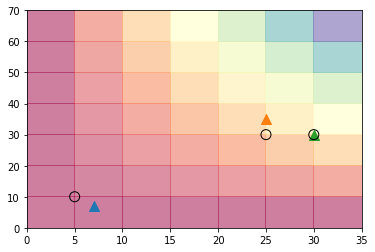

In [2]:
# Make a 2D grid
x, y = np.mgrid[0:40:5, 0:80:10]

# Create a KDTree object based on the grid
tree = spatial.KDTree(list(zip(x.ravel(), y.ravel())))
# You can print the data of the tree with `tree.data`

# Specify a set of points you wish to find the nearest neighbor for
pts = np.array([[7, 7], [25, 35], [30,30]])

# Query the points in the KDTree. Output is 
# 1) distance of point to the nearest grid neighbor
# 2) index of neighbor point in the tree.
dist_to_neighbor, idx_neighbor = tree.query(pts)

for point, dist, idx in zip(pts, dist_to_neighbor, idx_neighbor):
    print('The point %s is nearest the grid location %s and is %.2f units away.' \
          % (point, tree.data[idx], dist))

plt.pcolormesh(x, y, x*y, cmap="Spectral", alpha=.5)
for i in pts:
    plt.scatter(i[0], i[1], marker='^', s=100)

plt.scatter(tree.data[idx_neighbor][:,0], tree.data[idx_neighbor][:,1], facecolor='none', edgecolors='k', s=100)

---
# Example with HRRR data and point observation sites

In [3]:
# Create Map of HRRR model domain
m = draw_HRRR_map()

loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_i_2000.npy map from file


In [4]:
# Get the HRRR latitude and longitude grid
lat, lon = get_hrrr_latlon(DICT=False)

### Create a KDTree object all points of the grid
Creating the KDTree requres the latitude and longitude points to be in a single row (not a 2D array). There are two possible ways to do this. Both lines below do the essentially the same thing. The numpy way is a bit faster:

    np.column_stack([lon.ravel(), lat.ravel()])
    
    list(zip(lon.ravel(), lat.ravel()))  


In [5]:
timer = datetime.now()

tree = spatial.KDTree(np.column_stack([lon.ravel(), lat.ravel()]))

print(datetime.now()-timer)

0:00:11.407887


Look at the `tree` object data we just created...

In [6]:
tree.data

array([[-122.72   ,   21.138  ],
       [-122.69333,   21.14499],
       [-122.66666,   21.15197],
       ...,
       [ -60.99096,   47.86295],
       [ -60.95439,   47.85267],
       [ -60.91784,   47.84238]])

If we have a point at 41 North, -110 West, we can use the tree to find the nearest HRRR grid point. The first number returned is the distance between the queried point and the nearest HRRR grid point (in degrees lat/lon). The second number is the index of the HRRR grid point in the tree object.

In [7]:
point = np.array([-110, 41])
tree.query(point)

(0.016119320705285715, 1162704)

In [8]:
dist, idx = tree.query(point)
print('%s is nearest to HRRR grid point %s' % (point, tree.data[idx]))

[-110   41] is nearest to HRRR grid point [-110.01113   41.01166]


## Now lets get the nearest neighbor for lots of station points!

Get all NWS and RAWS station locations from the SynopticLabs API
https://developers.synopticdata.com/mesonet/

In [9]:
# Build the MesoWest API request. Network number 1 and 2 are NWS and RAWS, respectively.
URL = 'http://api.mesowest.net/v2/stations/metadata?' \
      + '&token=' + get_MW_token() \
      + '&network=1,2'

# Retrieve the MesoWest data
NWS = load_json(URL)


Retrieving from MesoWest API: http://api.mesowest.net/v2/stations/metadata?&token=2562b729557f45f5958516081f06c9eb&network=1,2



Unpack the data we want (station name, ID, and latitidue/longitude)

In [10]:
stn_lons = np.array([stn['LONGITUDE'] for stn in NWS['STATION']], dtype=float)
stn_lats = np.array([stn['LATITUDE'] for stn in NWS['STATION']], dtype=float)
stn_names = np.array([stn['NAME'] for stn in NWS['STATION']])
stn_ids = np.array([stn['STID'] for stn in NWS['STATION']])

print("Total of %s stations" % len(stn_lons))

stn_points = np.column_stack([stn_lons, stn_lats])

Total of 6730 stations


In [11]:
stn_points

array([[-111.96503 ,   40.77069 ],
       [-111.99016 ,   40.6196  ],
       [-111.96229 ,   41.11112 ],
       ...,
       [   0.      ,    0.      ],
       [   0.      ,    0.      ],
       [-115.254167,   43.728611]])

## Plot station location on HRRR domain
In a plain scatter plot, we see there are many stations outside the HRRR domain (Alaska, Hawaii, bad metadata?) We can filter these out when we do the KDTree query with `distance_upper_bound`.

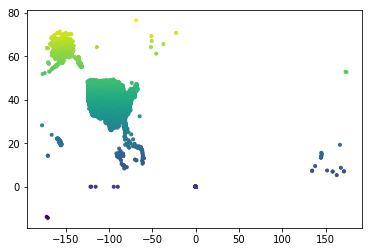

In [12]:
plt.scatter(stn_lons, stn_lats, marker='.', c=stn_lats)

We can filter these out by setting an upper bound on the distance of the neighbor. We don't want to consider any stations whose distance is larger than 0.05 degrees. Distances larger than that threshold are flagged as `inf`.

In [13]:
timer = datetime.now()
dist, locs = tree.query(stn_points, distance_upper_bound=0.05)
print(datetime.now()-timer)

0:00:02.011886


In [14]:
print('Maximum distance between station and HRRR gridpoint: %.3f degrees' % np.max(dist[dist!=np.inf]))
print('%s out of %s stations within the distance threshold' % (len(dist[dist!=np.inf]), len(dist)))

Maximum distance between station and HRRR gridpoint: 0.042 degrees
5892 out of 6730 stations within the distance threshold


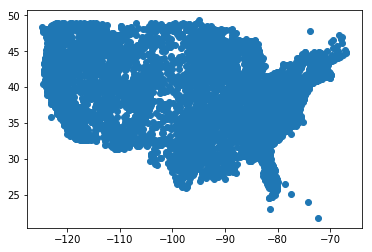

In [15]:
xs = tree.data[locs[dist!=np.inf]][:,0]
ys = tree.data[locs[dist!=np.inf]][:,1]
plt.scatter(xs, ys)

In [16]:
z = draw_centermap(center='KSLC', size=[.6,.6])


Retrieving from MesoWest API: http://api.mesowest.net/v2/stations/metadata?&token=2562b729557f45f5958516081f06c9eb&stid=KSLC



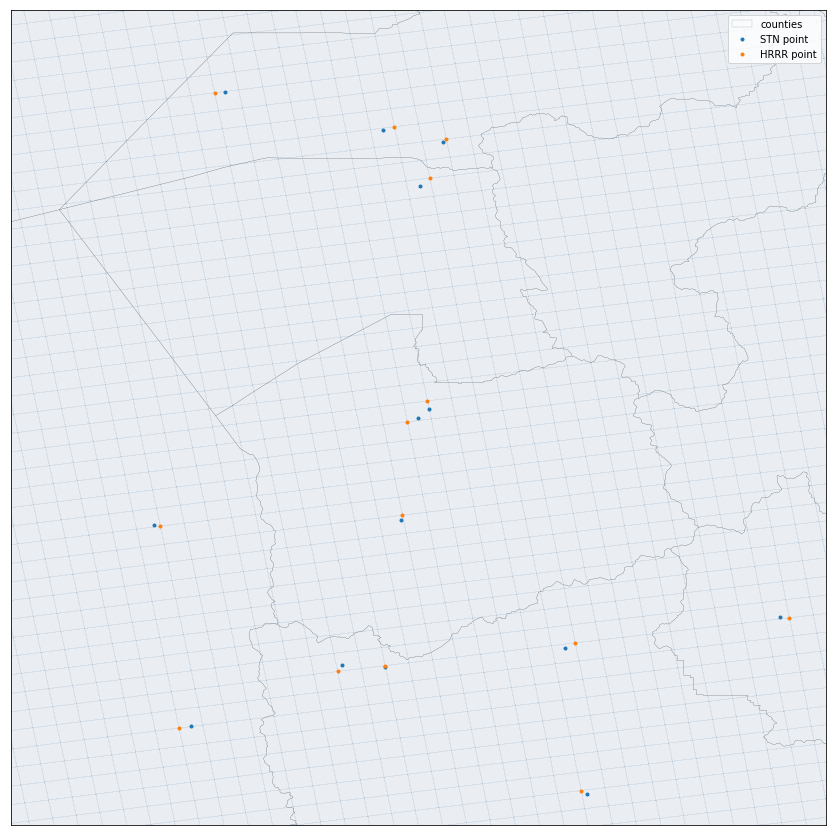

In [17]:
plt.figure(figsize=[15,15])
z.drawstates(); z.drawcounties()
z.pcolormesh(lon, lat, lon, alpha=.1, latlon=True)  # Shows HRRR gridpoints
z.scatter(stn_lons, stn_lats, latlon=True, marker='.', label='STN point')
z.scatter(xs, ys, latlon=True, marker='.', label='HRRR point')
plt.legend()

In [18]:
len(np.unique(locs))

5377

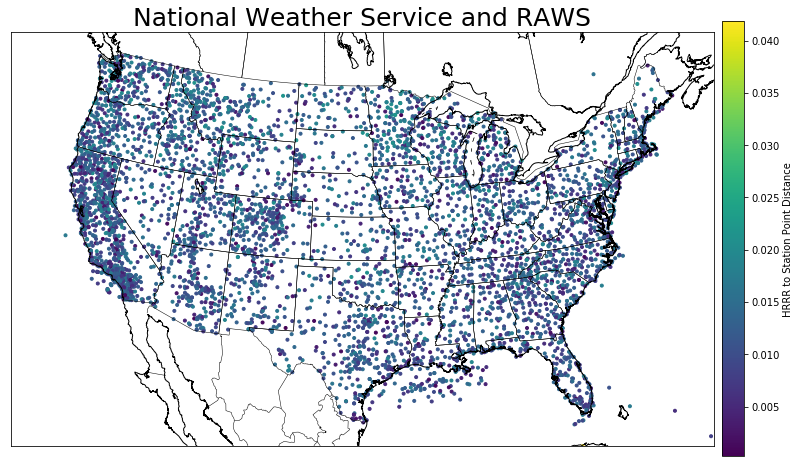

In [19]:
plt.figure(figsize=[15,10])
m.scatter(stn_lons[dist!=np.inf], stn_lats[dist!=np.inf], latlon=True, marker='.', c=dist[dist!=np.inf])
m.drawcountries(); m.drawstates(); m.drawcoastlines()
plt.title('National Weather Service and RAWS', fontsize=25)
plt.colorbar(label='HRRR to Station Point Distance', shrink=.8, pad=.01)

# What if we didn't use the distance threshold? `distance_upper_bound`
Well, not every NWS and RAWS station is within the HRRR domain, so we would have points that are very far from the nearest neighbor.

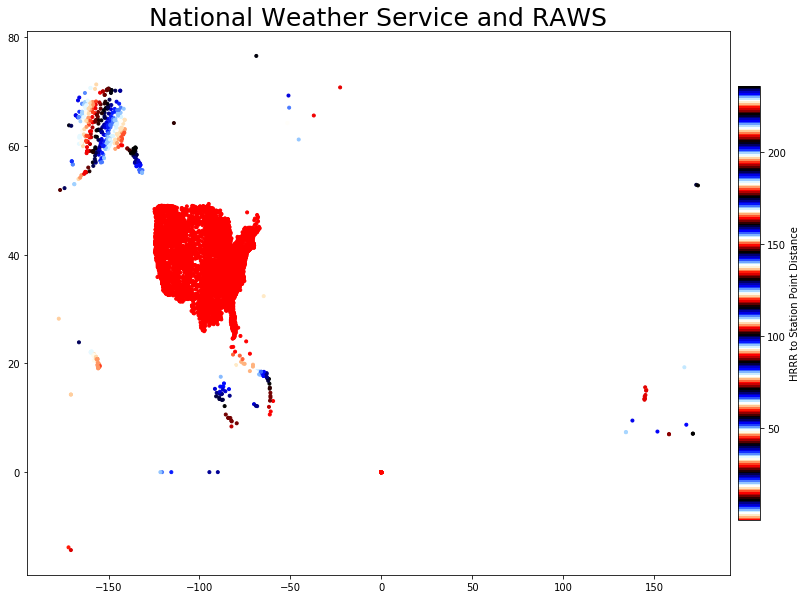

In [20]:
# results for no threshold
dist_nt, locs_nt = tree.query(stn_points)

plt.figure(figsize=[15,10])
plt.scatter(stn_lons, stn_lats, marker='.', c=dist_nt, cmap='flag')
plt.title('National Weather Service and RAWS', fontsize=25)
plt.colorbar(label='HRRR to Station Point Distance', shrink=.8, pad=.01)